## 1. Setup and Imports

*Import necessary libraries for data manipulation, clustering, evaluation, visualization, and statistical analysis. Configure warnings.*

In [ ]:
# --- Data Handling & Core ---
import pandas as pd
import numpy as np
import warnings

# --- Scikit-learn ---
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# --- Statistics ---
from scipy.stats import f_oneway, chi2_contingency

# Optional: Display settings
# pd.options.display.max_columns = 10
# pd.set_option('display.width', 1000)

## 2. Configuration Parameters

*Define parameters for the clustering process, such as whether to search for optimal K, the default K value, and the primary model to use for profiling.*

In [ ]:
# --- Clustering Specific Configuration ---
FIND_OPTIMAL_K = True # Set to False to skip elbow/silhouette plots for K
K_VALUE = 4           # Default K if FIND_OPTIMAL_K is False, or manually set after viewing plots
MODEL_FOR_PROFILING = 'KMeans' # Use 'KMeans' or 'GMM' labels for profiling

## 3. Data Loading and Preparation

*Load the employee survey dataset, handle boolean features, and separate the features (X) intended for clustering, while retaining the original JobSatisfaction (y) for later.*

In [ ]:
# --- Load Data ---
print("Loading & Preparing Data")
df = pd.read_csv('employee_survey.csv')
df_original = df.copy()

# --- Initial Prep ---
df = df.drop('EmpID', axis=1)
df['haveOT'] = df['haveOT'].map({True: 1, False: 0})
y_satisfaction = df['JobSatisfaction'].copy() # Keep original satisfaction scores
X = df.drop(['JobSatisfaction'], axis=1) # Features for clustering

print(f"Feature set shape for clustering: {X.shape}")

--- Loading & Preparing Data ---
Feature set shape for clustering: (3025, 21)


## 4. Feature Preprocessing

*Define numerical, nominal, and ordinal features. Set up and apply preprocessing steps: StandardScaler for numerical features, OneHotEncoder for nominal, and OrdinalEncoder (followed by StandardScaler) for ordinal features. No imputations are needed for this dataset.*

In [ ]:
# --- Define Feature Types ---
print("\nSetting up Preprocessing Pipelines")
job_level_order = ['Intern/Fresher', 'Junior', 'Mid', 'Senior', 'Lead']
edu_level_order = ['High School', 'Bachelor', 'Master', 'PhD']
ordinal_features = ['JobLevel', 'EduLevel']
nominal_features = ['Gender', 'MaritalStatus', 'Dept', 'EmpType', 'CommuteMode']
numerical_features = ['Age', 'Experience', 'WLB', 'WorkEnv', 'PhysicalActivityHours',
                      'Workload', 'Stress', 'SleepHours', 'CommuteDistance', 'NumCompanies',
                      'TeamSize', 'NumReports', 'TrainingHoursPerYear', 'haveOT']
categorical_features = nominal_features + ordinal_features # Combined list for later analysis

# --- Create Transformers (No Imputers) ---
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
nominal_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])
ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder(categories=[job_level_order, edu_level_order], handle_unknown='use_encoded_value', unknown_value=-1)),
                                      ('scaler', StandardScaler())]) # Scale ordinal after encoding

# --- Create Preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('nom', nominal_transformer, nominal_features),
        ('ord', ordinal_transformer, ordinal_features)],
    remainder='passthrough', verbose_feature_names_out=False)

# --- Apply Preprocessing ---
X_processed = preprocessor.fit_transform(X)
try:
    processed_feature_names = preprocessor.get_feature_names_out()
    print(f"Preprocessing complete. Processed data shape: {X_processed.shape}")
except Exception as e:
    print(f"Warning: Could not get feature names: {e}")
    processed_feature_names = None


--- Setting up Preprocessing Pipelines ---
Preprocessing complete. Processed data shape: (3025, 34)


## 5. Dimensionality Reduction (PCA for Visualization)

*Apply PCA to reduce the processed data to 2 and 3 dimensions to facilitate visualization of the clusters and assess variance within the dataset.*

In [ ]:
# --- Apply PCA ---
print("\n--- Applying PCA for Visualization ---")
pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_processed)
pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_processed)
print(f"Explained Variance (2D PCA): {np.sum(pca_2d.explained_variance_ratio_):.3f}")
print(f"Explained Variance (3D PCA): {np.sum(pca_3d.explained_variance_ratio_):.3f}")


--- Applying PCA for Visualization ---
Explained Variance (2D PCA): 0.347
Explained Variance (3D PCA): 0.406


## 6. Optimal Cluster Number (K) Determination

*Use the Elbow Method (inertia) and Silhouette Score analysis for K-Means to find the optimal number of clusters (k) if FIND_OPTIMAL_K is set to True.*


 Finding Optimal K for K-means (2 to 10 clusters)
Silhouette Scores: k=2-10 -> ['0.175', '0.108', '0.090', '0.089', '0.081', '0.082', '0.086', '0.075', '0.078']
--> Recommended K from Silhouette: 2


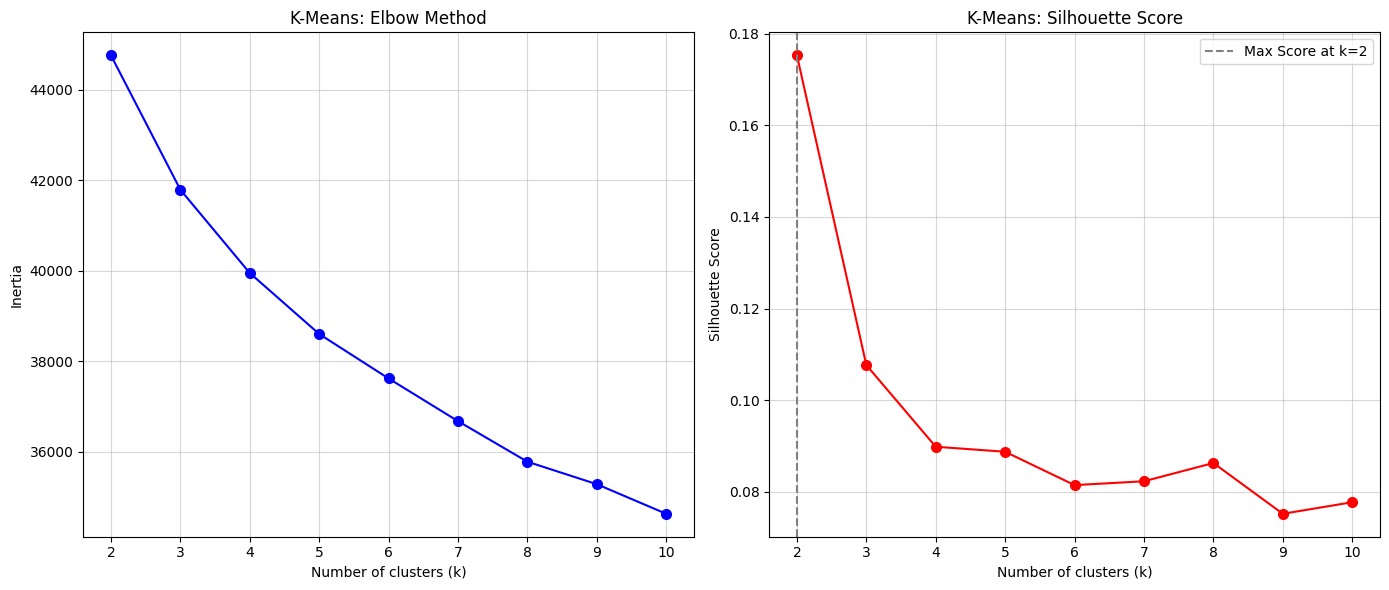


--> NOTE: Using K_VALUE = 4 set in the config cell


In [ ]:
# --- Find Optimal K (if configured) ---
if FIND_OPTIMAL_K:
    print("\n Finding Optimal K for K-means (2 to 10 clusters)")
    inertias = []
    silhouette_scores_k = []
    k_range = range(2, 11)

    for k_i in k_range:
        kmeans_i = KMeans(n_clusters=k_i, random_state=42, n_init=10).fit(X_processed)
        inertias.append(kmeans_i.inertia_)
        try:
            score = silhouette_score(X_processed, kmeans_i.labels_)
            silhouette_scores_k.append(score)
        except ValueError: silhouette_scores_k.append(np.nan)

    # --- Plotting Elbow and Silhouette ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    # Elbow Plot
    axes[0].plot(k_range, inertias, 'bo-', markersize=7)
    axes[0].set_xlabel('Number of clusters (k)'); axes[0].set_ylabel('Inertia')
    axes[0].set_title('K-Means: Elbow Method'); axes[0].grid(True, alpha=0.5)
    # Silhouette Plot
    valid_scores = [(k, s) for k, s in zip(k_range, silhouette_scores_k) if not pd.isna(s)]
    if valid_scores:
        valid_k, valid_s = zip(*valid_scores)
        axes[1].plot(valid_k, valid_s, 'ro-', markersize=7)
        recommended_k_sil = valid_k[np.argmax(valid_s)]
        axes[1].axvline(recommended_k_sil, color='grey', linestyle='--', label=f'Max Score at k={recommended_k_sil}')
        axes[1].legend()
        print(f"Silhouette Scores: k=2-10 -> {[f'{s:.3f}' if not pd.isna(s) else 'N/A' for s in silhouette_scores_k]}")
        print(f"--> Recommended K from Silhouette: {recommended_k_sil}")
    else: print("Could not calculate silhouette scores.")
    axes[1].set_xlabel('Number of clusters (k)'); axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('K-Means: Silhouette Score'); axes[1].grid(True, alpha=0.5)
    plt.tight_layout(); plt.show()
    print(f"\n--> NOTE: Using K_VALUE = {K_VALUE} set in the config cell")
else:
    print(f"\n--- Skipping Optimal K search, using K_VALUE = {K_VALUE} ---")

# Use the configured K value moving forward
k_to_use = K_VALUE

## 7. Run Clustering Models

*Run K-Means and Gaussian Mixture Model (GMM) clustering algorithms using the selected number of clusters (k).*

In [ ]:
# --- Run Clustering Algorithms ---
print(f"\n Running Clustering Algorithms (k/n={k_to_use}) ")

# K-Means
kmeans = KMeans(n_clusters=k_to_use, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_processed)
print(f"K-Means fitting complete. Found {len(np.unique(kmeans_labels))} clusters.")

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=k_to_use, random_state=42, covariance_type='full', n_init=5)
gmm_labels = gmm.fit_predict(X_processed)
print(f"GMM fitting complete. Found {len(np.unique(gmm_labels))} components/clusters.")


 Running Clustering Algorithms (k/n=4) 
K-Means fitting complete. Found 4 clusters.
GMM fitting complete. Found 4 components/clusters.


## 8. Clustering Evaluation (Silhouette Score)

*Evaluate the quality of the clusters produced by K-Means and GMM using the Silhouette Score.*

In [ ]:
# --- Calculate and Compare Silhouette Scores ---
print("\n Clustering Evaluation (Silhouette Score)")
kmeans_sil = silhouette_score(X_processed, kmeans_labels) if len(np.unique(kmeans_labels)) > 1 else np.nan
gmm_sil = silhouette_score(X_processed, gmm_labels) if len(np.unique(gmm_labels)) > 1 else np.nan

print(f"  - K-Means Silhouette: {kmeans_sil:.4f}" if not pd.isna(kmeans_sil) else "  - K-Means Silhouette: N/A")
print(f"  - GMM Silhouette:     {gmm_sil:.4f}" if not pd.isna(gmm_sil) else "  - GMM Silhouette: N/A")


 Clustering Evaluation (Silhouette Score)
  - K-Means Silhouette: 0.0898
  - GMM Silhouette:     0.0560


## 9. Cluster Visualization

*Visualize the clusters identified by K-Means and GMM projected onto the first 2 and 3 Principal Components.*


 Visualizing Clusters using PCA 


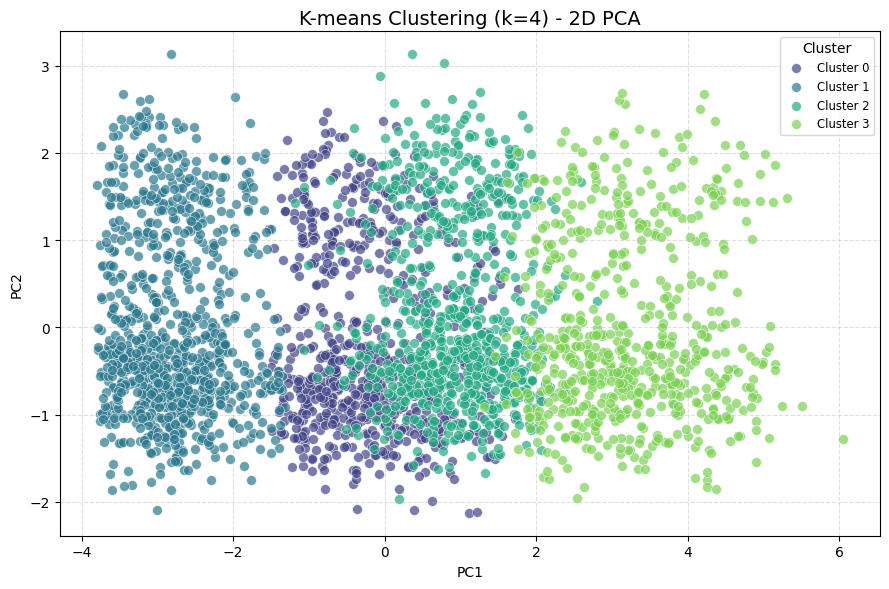

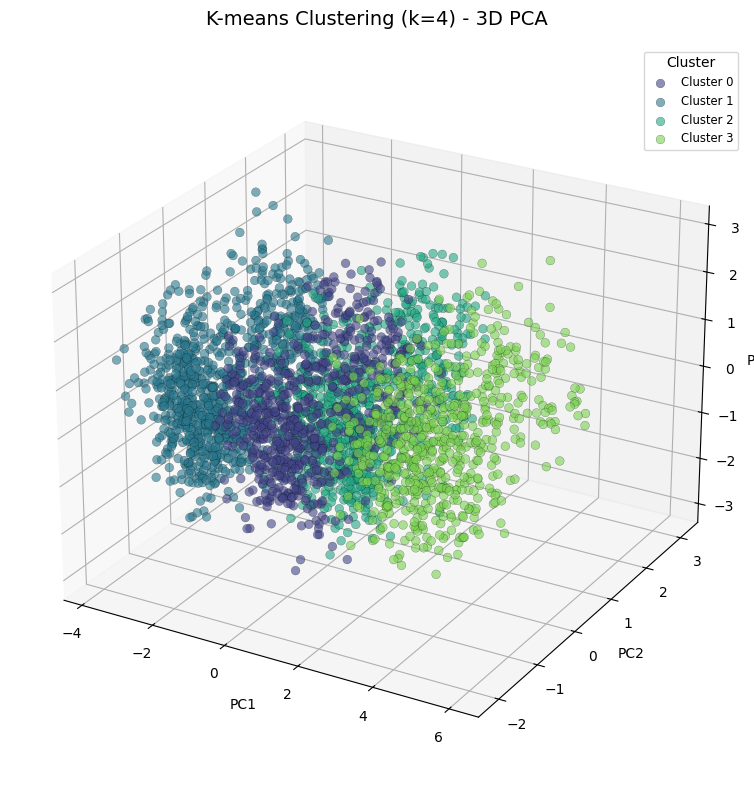

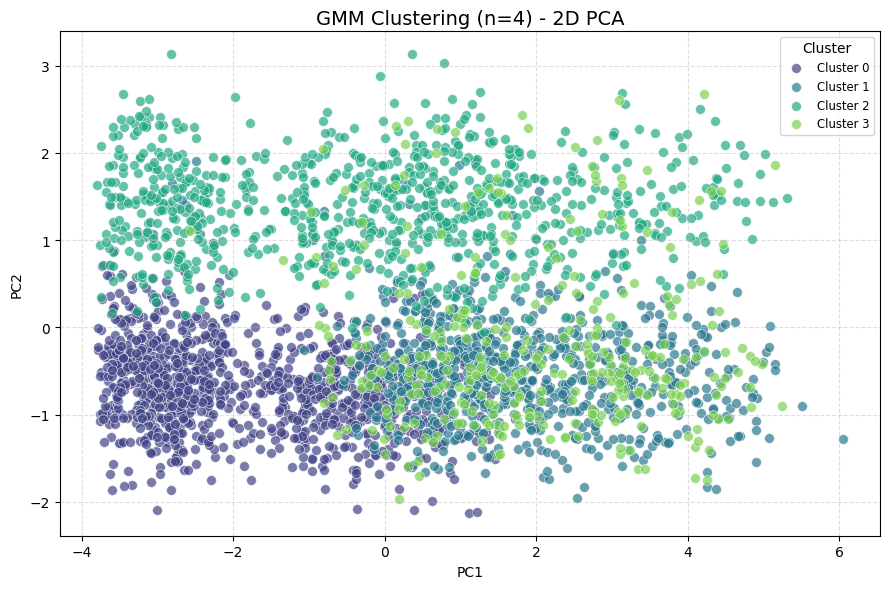

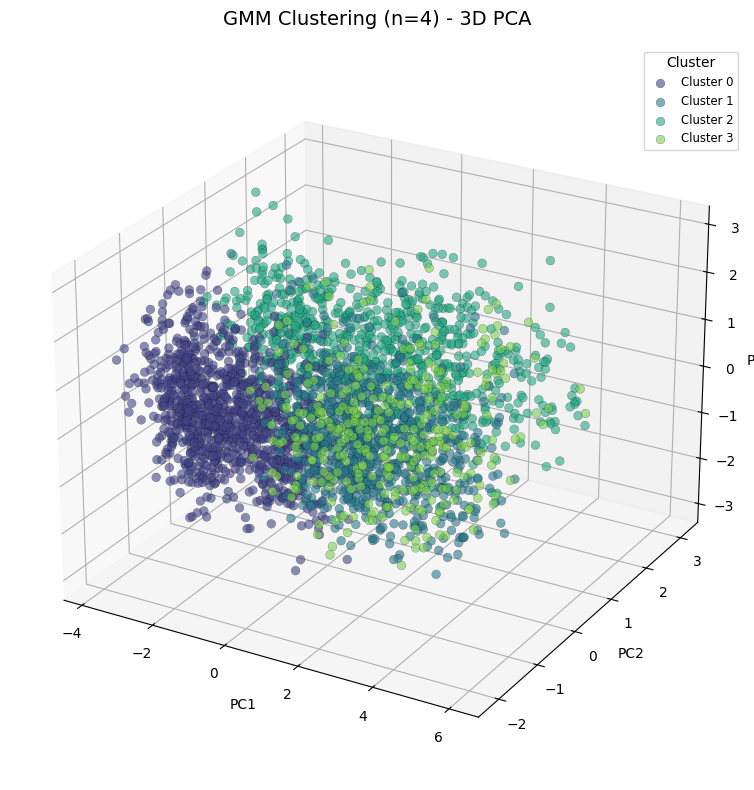

In [ ]:
# --- Define Plotting Function ---
def plot_clusters(X_pca, labels, title, is_3d=False):
    """Helper function to plot clusters in 2D or 3D using PCA results."""
    plt.figure(figsize=(11, 8) if is_3d else (9, 6))
    unique_labels = np.unique(labels)
    colors = sns.color_palette("viridis", n_colors=len(unique_labels))
    ax = plt.axes(projection='3d') if is_3d else plt.gca()

    for k, col in zip(unique_labels, colors):
        mask = (labels == k)
        coords = X_pca[mask]
        if is_3d:
            ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], c=[col], label=f'Cluster {k}',
                       s=40, alpha=0.6, edgecolor='k', linewidth=0.2)
        else:
            ax.scatter(coords[:, 0], coords[:, 1], c=[col], label=f'Cluster {k}',
                       s=50, alpha=0.7, edgecolor='w', linewidth=0.5)

    ax.set_title(title, fontsize=14, pad=15 if is_3d else 5)
    ax.set_xlabel('PC1', fontsize=10); ax.set_ylabel('PC2', fontsize=10)
    if is_3d: ax.set_zlabel('PC3', fontsize=10); ax.view_init(elev=25., azim=-60)
    if len(unique_labels) < 10: ax.legend(title="Cluster", loc='best', fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout(); plt.show()

# --- Plot Clusters ---
print("\n Visualizing Clusters using PCA ")
# Plot K-Means
plot_clusters(X_pca_2d, kmeans_labels, f'K-means Clustering (k={k_to_use}) - 2D PCA')
plot_clusters(X_pca_3d, kmeans_labels, f'K-means Clustering (k={k_to_use}) - 3D PCA', is_3d=True)

# Plot GMM
plot_clusters(X_pca_2d, gmm_labels, f'GMM Clustering (n={k_to_use}) - 2D PCA')
plot_clusters(X_pca_3d, gmm_labels, f'GMM Clustering (n={k_to_use}) - 3D PCA', is_3d=True)

## 10. Cluster Profiling Setup

*Select the cluster labels from the chosen model and prepare the `analysis_df` by adding cluster labels and original JobSatisfaction scores back to the original data.*

In [ ]:
# --- Select Labels and Prepare DataFrame for Profiling ---
print(f"\n Preparing for Cluster Profiling (Using {MODEL_FOR_PROFILING} Results) ")

if MODEL_FOR_PROFILING == 'GMM' and 'gmm_labels' in locals():
    labels_for_profiling = gmm_labels
    print("Using GMM labels for analysis.")
elif MODEL_FOR_PROFILING == 'KMeans' and 'kmeans_labels' in locals():
    labels_for_profiling = kmeans_labels
    print("Using KMeans labels for analysis.")
else:
    print(f"Warning: Specified MODEL_FOR_PROFILING '{MODEL_FOR_PROFILING}' not found or labels missing. Defaulting to KMeans.")
    labels_for_profiling = kmeans_labels
    if 'kmeans_labels' not in locals():
        raise ValueError("Cannot proceed with profiling - K-Means labels not found.")

# Create analysis dataframe
analysis_df = df_original.copy() # Use the clean original copy
analysis_df['Cluster'] = labels_for_profiling
# Ensure JobSatisfaction is present (it was kept in df_original)
# analysis_df['JobSatisfaction'] = y_satisfaction # Not needed if df_original has it

print(f"Analysis DataFrame shape: {analysis_df.shape}")


 Preparing for Cluster Profiling (Using KMeans Results) 
Using KMeans labels for analysis.
Analysis DataFrame shape: (3025, 24)


## 11. Numerical Cluster Profiling

*Calculate and display summary statistics (mean values and cluster size) for key numerical features across the identified clusters to assess which features are causing the variance.*

In [ ]:
# --- Numerical Profile Summary (Mean Values) ---
print("\n Numerical Cluster Profiling")
# Focus on a subset of key numerical indicators for concise profiling
numerical_profile_features = ['JobSatisfaction', 'Age', 'Experience', 'WLB', 'WorkEnv', 'Stress', 'SleepHours', 'TrainingHoursPerYear']
cluster_numerical_summary = analysis_df.groupby('Cluster')[numerical_profile_features].mean()
cluster_sizes = analysis_df['Cluster'].value_counts().sort_index()
cluster_numerical_summary.insert(0, 'Cluster Size', cluster_sizes)
print("\nCluster Profiles (Mean Numerical Values):")
print(cluster_numerical_summary.round(2))


 Numerical Cluster Profiling

Cluster Profiles (Mean Numerical Values):
         Cluster Size  JobSatisfaction    Age  Experience   WLB  WorkEnv  \
Cluster                                                                    
0                 670             3.37  37.24       11.22  3.15     2.95   
1                 932             3.39  24.95        2.70  3.06     3.00   
2                 781             3.40  35.04        9.11  3.08     3.06   
3                 642             3.38  50.69       16.07  2.94     3.11   

         Stress  SleepHours  TrainingHoursPerYear  
Cluster                                            
0          1.74        6.94                 36.09  
1          1.70        7.05                 20.56  
2          1.79        7.00                 44.77  
3          1.72        7.01                 53.78  


## 12. Categorical Cluster Profiling

*Determine and display the most frequent category for key categorical features within each cluster.*

In [ ]:
# --- Categorical Profile Summary (Most Frequent Value) ---
print("\n Categorical Cluster Profiling ")
# Focus on a subset of key categorical indicators
categorical_profile_features = ['JobLevel', 'Dept', 'EduLevel', 'MaritalStatus', 'EmpType']
cluster_categorical_summary = analysis_df.groupby('Cluster')[categorical_profile_features].agg(lambda x: x.mode()[0] if not x.mode().empty else 'N/A')
# Reuse cluster_sizes calculated earlier
cluster_categorical_summary.insert(0, 'Cluster Size', cluster_sizes)
print("\nCluster Profiles (Most Frequent Categorical Values):")
print(cluster_categorical_summary)


 Categorical Cluster Profiling 

Cluster Profiles (Most Frequent Categorical Values):
         Cluster Size JobLevel Dept  EduLevel MaritalStatus    EmpType
Cluster                                                               
0                 670      Mid   IT  Bachelor       Married  Full-Time
1                 932   Junior   IT  Bachelor        Single  Full-Time
2                 781   Senior   IT  Bachelor       Married  Full-Time
3                 642     Lead   IT  Bachelor       Married  Full-Time


## 13. Feature Importance for Cluster Separation

*Calculate feature importance scores (ANOVA F-statistic for numerical, Chi-Squared for categorical) to identify which original features most strongly differentiate the clusters. Visualize the top features.*


 Feature Importance for Cluster Separation

Feature Importance Scores (Top 15):
                      Statistic  p-value         Type
TrainingHoursPerYear  6315.2090   0.0000    Numerical
JobLevel              6165.8437   0.0000  Categorical
Age                   4235.1760   0.0000    Numerical
NumCompanies          4143.9007   0.0000    Numerical
NumReports            2055.9788   0.0000    Numerical
EduLevel              1174.2173   0.0000  Categorical
MaritalStatus         1167.8052   0.0000  Categorical
TeamSize               968.1119   0.0000    Numerical
Experience             922.1868   0.0000    Numerical
CommuteMode             12.9997   0.3691  Categorical
Dept                    12.0442   0.9384  Categorical
EmpType                  5.7404   0.4529  Categorical
Gender                   5.3492   0.4999  Categorical
WLB                      2.4299   0.0634    Numerical
Workload                 1.7655   0.1516    Numerical


<ipython-input-16-4615f61c4b23>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=importance_df.index[:top_n_imp], x=importance_df['Statistic'][:top_n_imp], palette='plasma')


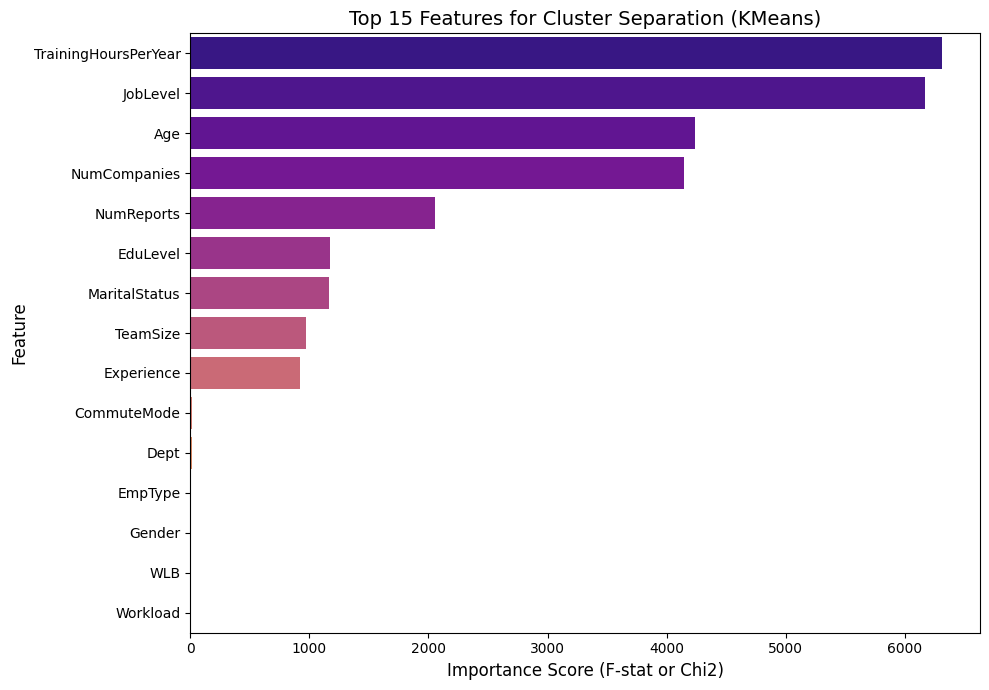

In [ ]:
# --- Calculate Feature Importance ---
print("\n Feature Importance for Cluster Separation")
feature_importance = {}
# Calculate ANOVA F-statistic
# print("  Calculating ANOVA F-statistic...") # Optional print
for feature in numerical_features:
    groups = [analysis_df[feature][analysis_df['Cluster'] == c].dropna() for c in analysis_df['Cluster'].unique()]
    groups = [g for g in groups if len(g) > 1]; f_stat, p_val = (np.nan, np.nan)
    if len(groups) > 1:
        try: f_stat, p_val = f_oneway(*groups)
        except ValueError: pass # Catch potential errors like zero variance
    feature_importance[feature] = {'Statistic': f_stat, 'p-value': p_val, 'Type': 'Numerical'}

# Calculate Chi-Squared
# print("  Calculating Chi-Squared statistic...") # Optional print
for feature in categorical_features: # Use the combined list defined earlier
    contingency_table = pd.crosstab(analysis_df[feature], analysis_df['Cluster'])
    chi2, p_val = (np.nan, np.nan)
    if contingency_table.shape[0] > 1 and contingency_table.shape[1] > 1 and contingency_table.sum().sum() > 0:
        try: chi2, p_val, _, _ = chi2_contingency(contingency_table)
        except ValueError: pass
    feature_importance[feature] = {'Statistic': chi2, 'p-value': p_val, 'Type': 'Categorical'}

# --- Display Feature Importance ---
importance_df = pd.DataFrame.from_dict(feature_importance, orient='index').fillna(0)
importance_df['Statistic'] = importance_df['Statistic'].abs() # Sort by magnitude
importance_df = importance_df.sort_values('Statistic', ascending=False)
print("\nFeature Importance Scores (Top 15):")
print(importance_df[['Statistic', 'p-value', 'Type']].round(4).head(15))

# --- Visualize Feature Importance ---
plt.figure(figsize=(10, 7))
top_n_imp = 15
sns.barplot(y=importance_df.index[:top_n_imp], x=importance_df['Statistic'][:top_n_imp], palette='plasma')
plt.title(f'Top {top_n_imp} Features for Cluster Separation ({MODEL_FOR_PROFILING})', fontsize=14)
plt.xlabel('Importance Score (F-stat or Chi2)', fontsize=12)
plt.ylabel('Feature', fontsize=12); plt.tight_layout(); plt.show()

## 14. Cluster Profile Visualization

*Visualize the distributions of the top distinguishing numerical and categorical features across the clusters.*

<ipython-input-17-37b486f710e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=analysis_df, palette='viridis')
<ipython-input-17-37b486f710e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=analysis_df, palette='viridis')
<ipython-input-17-37b486f710e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=analysis_df, palette='viridis')
<ipython-input-17-37b486f710e1>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be r

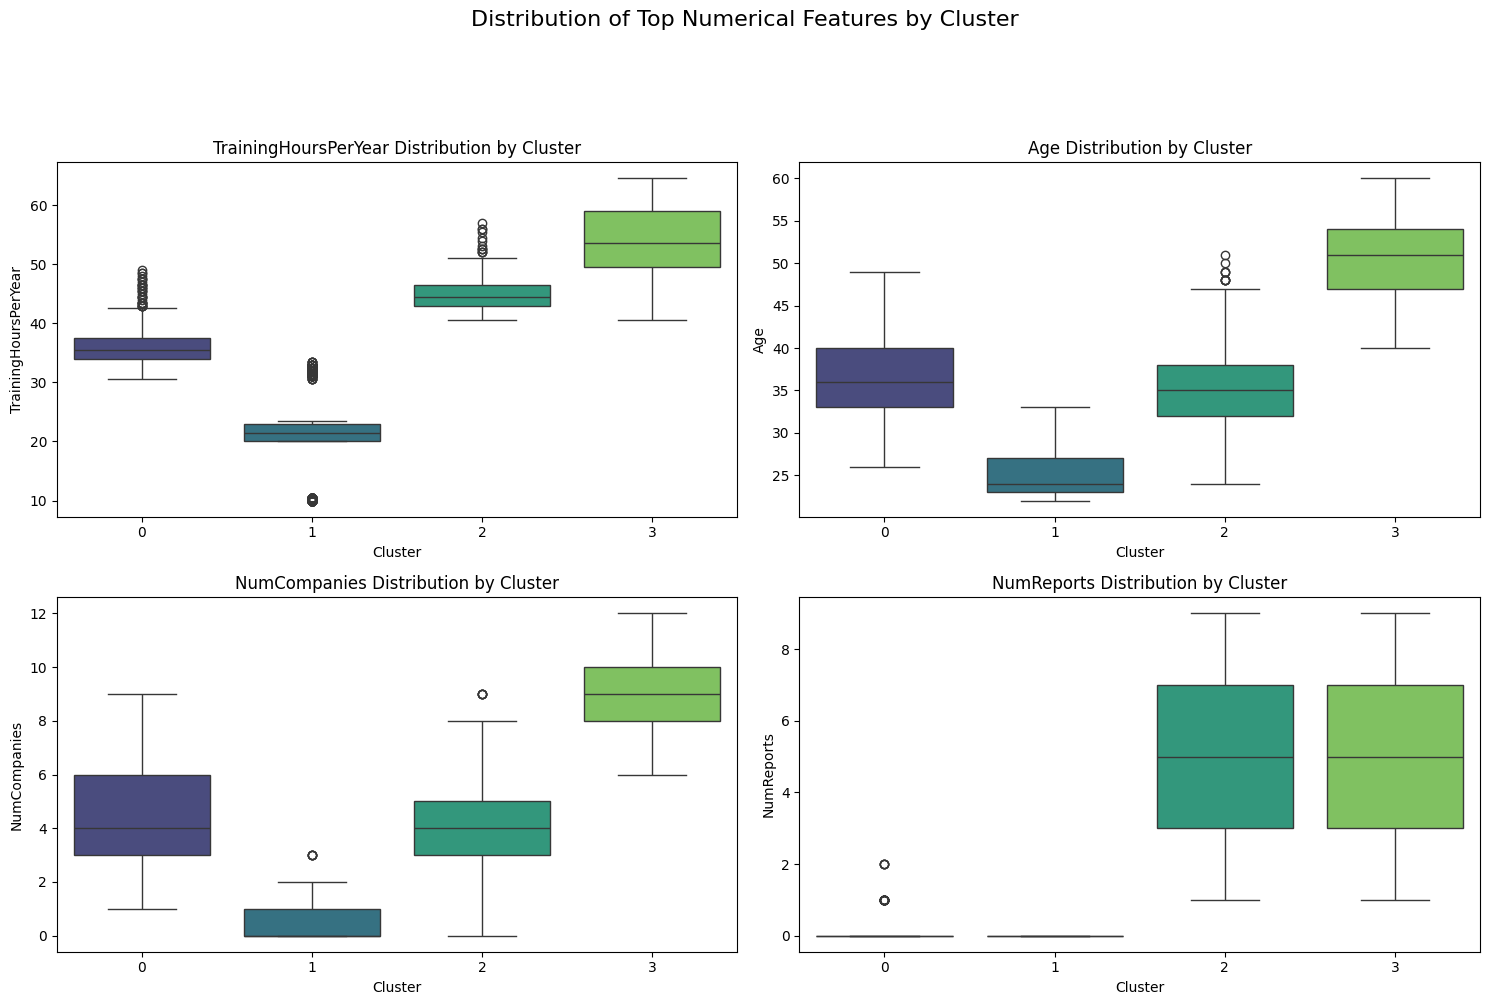

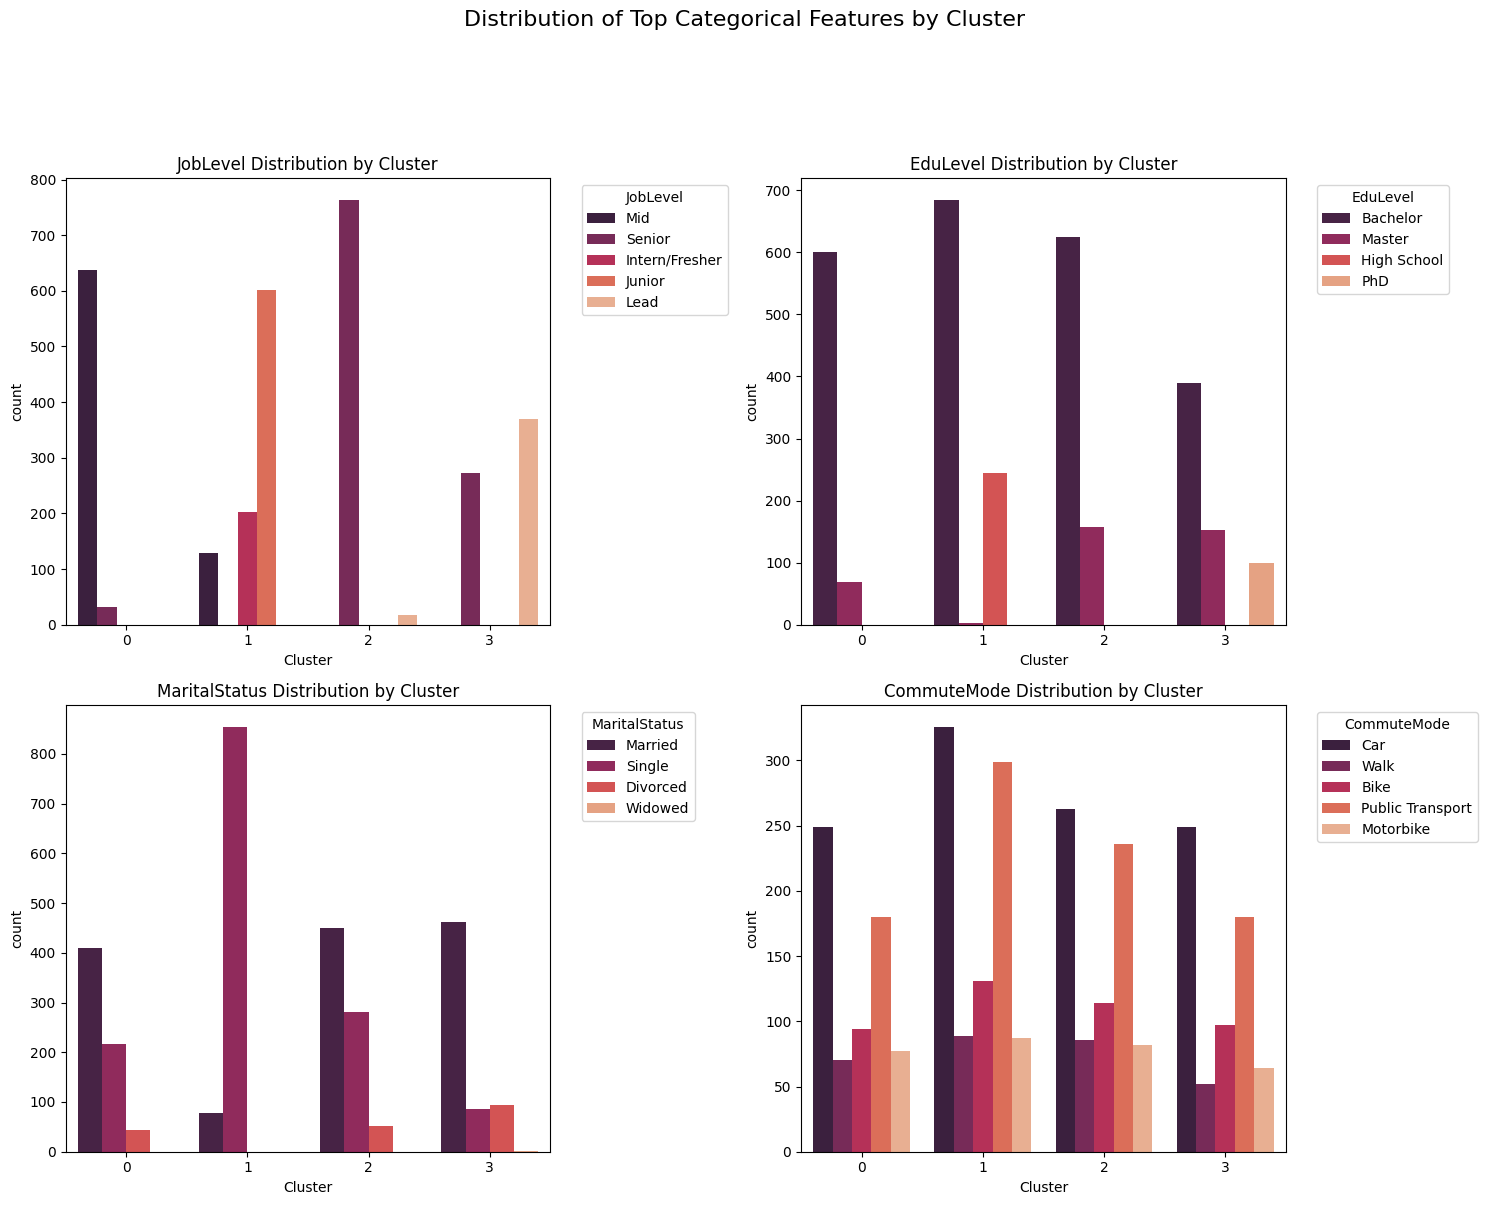

In [ ]:
# --- Visualize Key Profile Differences ---
# Box Plots for Top Numerical Features by Importance
top_numerical = importance_df[importance_df['Type'] == 'Numerical'].index[:4].tolist()
if top_numerical:
    n_rows_num = (len(top_numerical) + 1) // 2
    plt.figure(figsize=(15, 5 * n_rows_num)) # Adjusted figsize
    for i, feature in enumerate(top_numerical):
        plt.subplot(n_rows_num, 2, i + 1)
        sns.boxplot(x='Cluster', y=feature, data=analysis_df, palette='viridis')
        plt.title(f'{feature} Distribution by Cluster')
    plt.suptitle('Distribution of Top Numerical Features by Cluster', y=1.03, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Count Plots for Top Categorical Features by Importance
top_categorical = importance_df[importance_df['Type'] == 'Categorical'].index[:4].tolist()
if top_categorical:
    n_rows_cat = (len(top_categorical) + 1) // 2
    plt.figure(figsize=(15, 6 * n_rows_cat))
    for i, feature in enumerate(top_categorical):
        plt.subplot(n_rows_cat, 2, i + 1)
        sns.countplot(data=analysis_df, x='Cluster', hue=feature, palette='rocket')
        plt.title(f'{feature} Distribution by Cluster')
        plt.legend(title=feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.suptitle('Distribution of Top Categorical Features by Cluster', y=1.03, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()